## Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Library to support working with data
import pandas as pd
import numpy as np

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Training model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping

# Performance metrics calculation support library
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


# Graphing support library
from matplotlib import ticker
import matplotlib.pyplot as plt

## Data preprocessing

### Read data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


### Reset index

In [4]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [5]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [6]:
#  Scaler data
scaler = MinMaxScaler(feature_range = (0, 1))
df_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [7]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(len(df_scaled) * 0.7)
val_size = int(len(df_scaled) * 0.2)
test_size = len(df_scaled) - train_size - val_size

train_data = df_scaled[0 : train_size, :]
val_data = df_scaled[train_size : train_size + val_size, :]
test_data = df_scaled[train_size + val_size : len(df_scaled), :]

## Model training and testing

In [8]:
# Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
# Add data for train, validation and test set
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
# Make input for DFNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

### Training process

#### Optimization

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

In [12]:
# Reshape x_train, x_test, x_val to 2 dimensions
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
X_val_2d = X_val.reshape(X_val.shape[0], -1)

In [13]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (256,), (128, 64), (64, 32, 16), (128,64, 32)],
    'activation': ['relu'],
    'learning_rate': ['constant', 'adaptive'],
}

In [14]:
# Create the model
model = MLPRegressor()

In [15]:
# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)


In [16]:
# Fit the grid search to the training data
grid_search.fit(X_train_2d, y_train)

GridSearchCV(cv=5, estimator=MLPRegressor(),
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [(64,), (128,), (256,),
                                                (128, 64), (64, 32, 16),
                                                (128, 64, 32)],
                         'learning_rate': ['constant', 'adaptive']},
             scoring='neg_mean_squared_error')

In [17]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print parameters and best score
print(f'Params: ',best_params)
print(f'Best score:',best_score)

Params:  {'activation': 'relu', 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive'}
Best score: -0.0013665632214301475


In [18]:
# Create the model with the best parameters
best_model = MLPRegressor(hidden_layer_sizes=best_params['hidden_layer_sizes'], activation=best_params['activation'], learning_rate=best_params['learning_rate'])

In [19]:
# Train the best model
best_model.fit(X_train_2d, y_train )

MLPRegressor(hidden_layer_sizes=(128, 64), learning_rate='adaptive')

### Validate Processing

In [20]:
train_predict=best_model.predict(X_train_2d)
y_pred_val=best_model.predict(X_val_2d)

### Testing Processing

In [21]:
y_pred=best_model.predict(X_test_2d)

### Inverse

In [22]:

train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_data = scaler.inverse_transform(test_data.reshape(-1, 1))

y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))
ytest = scaler.inverse_transform(ytest.reshape(-1, 1))
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

### Evaluate Model

In [23]:
# Evaluate the accuracy of validation
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
val_mse = mean_squared_error(y_pred_val, y_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, y_val)

print(f"Validation MAPE: ", val_mape)
print(f"Validation RMSE: ", val_rmse)
print(f"Validation MSLE: ", val_msle)

Validation MAPE:  0.06144393840802546
Validation RMSE:  6.378693720572388
Validation MSLE:  0.008586646018694936


In [24]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, ytest)
test_mse = mean_squared_error(y_pred, ytest)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, ytest)

print(f"Testing MAPE: ", test_mape)
print(f"Testing RMSE: ", test_rmse)
print(f"Testing MSLE: ", test_msle)

Testing MAPE:  0.06920796706557204
Testing RMSE:  5.549874230306558
Testing MSLE:  0.012685187084948158


## Predicting the next 30 days

### Preparing the prediction data

In [25]:
x_input = val_data[5:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Reshape x_train, x_test, x_val to 2 dimensions
#X_train_2d = X_train.reshape(X_train.shape[0], -1)

# Define i
i = 0

# List storage value for next 30 days
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])

        x_input = x_input.reshape((1, time_step, 1))
        x_input = x_input.reshape((x_input.shape[0], x_input.shape[1]))

        y_hat = best_model.predict(x_input)

        temp_input.extend(y_hat.tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose = 0)

        temp_input.extend(y_hat.tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [26]:
# Print predict next 30 days
print(prediction_next30_days)

[0.12218838392673567, 0.12319588731231884, 0.1256391038637316, 0.12582580427299636, 0.13462410088888563, 0.13151897936398704, 0.1422462998107297, 0.14229976405046896, 0.14457568844428392, 0.1426471115197056, 0.1357181181334085, 0.13232767392939157, 0.1300388934852612, 0.1318501802668581, 0.13207866892013448, 0.13841432900466083, 0.13743276792828366, 0.13748137448663084, 0.13393461586905436, 0.1366711855222703, 0.13664315409116118, 0.13957190607975467, 0.13956093804083075, 0.1394468234771823, 0.13764983128622882, 0.13901189433913563, 0.13831282294545894, 0.13979815352426467, 0.14210275382592044, 0.14047619594067298]


### Preparing the forecast date index

In [27]:
# Get the last date from the current index
last_date = df.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [28]:
# Convert from list to array
prediction_next30_days = np.array(prediction_next30_days)

# Convert to normal values from 0, 1
prediction_next30_days = scaler.inverse_transform(prediction_next30_days.reshape(-1,1))

## Visualization

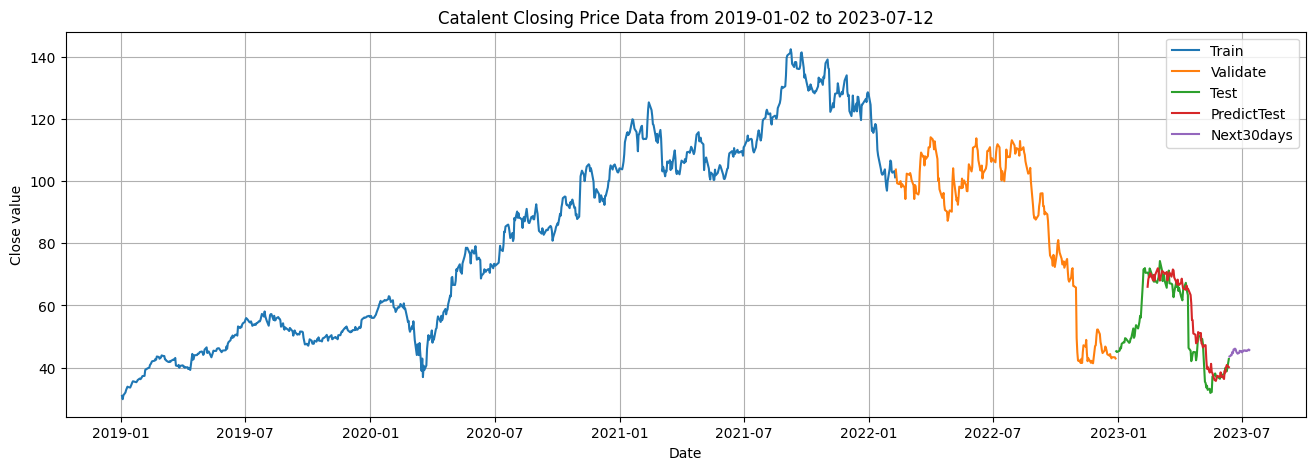

In [29]:
# Visualization
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], test_data)
plt.plot(df.index[train_size + val_size + time_step: ], y_pred)

plt.plot(future_dates, prediction_next30_days)

plt.legend(['Train','Validate','Test','PredictTest','Next30days'])

plt.grid()
plt.title(f"Catalent Closing Price Data from 2019-01-02 to 2023-07-12")
plt.xlabel("Date")
plt.ylabel("Close value")
#plt.savefig('../Image/DFNN_712_CTLT.png')
plt.show()